In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
BATCH_SIZE = 64
LR = 0.0001
N_EPOCHS = 50
GAMMA = 10  # Weight for Wasserstein distance loss
K_CRITIC = 5  # Train critic K times per generator step
CLIP_VALUE = 0.01  # Weight clipping for Lipschitz constraint
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Running WDGRL on {DEVICE}")

Running WDGRL on cuda


In [24]:
#Loading data
X_pdb = np.load('/content/drive/MyDrive/features/pdb_maps.npy')
X_af = np.load('/content/drive/MyDrive/features/af_maps.npy')
y = np.load('/content/drive/MyDrive/features/labels.npy')

# Split (same as naive, DANN, ADDA)
indices = np.arange(len(y))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y)

X_train_pdb = X_pdb[train_idx]
X_train_af = X_af[train_idx]
y_train = y[train_idx]

X_test_pdb = X_pdb[test_idx]
X_test_af = X_af[test_idx]
y_test = y[test_idx]

print(f"Train: {len(X_train_pdb)} | Test: {len(X_test_af)}")

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

Train: 9641 | Test: 2411


In [25]:
#Data Loaders
source_ds = TensorDataset(
    torch.tensor(X_train_pdb, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_train, dtype=torch.long)
)
source_loader = DataLoader(source_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

target_ds = TensorDataset(
    torch.tensor(X_train_af, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_train, dtype=torch.long)
)
target_loader = DataLoader(target_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_pdb_ds = TensorDataset(
    torch.tensor(X_test_pdb, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_test, dtype=torch.long)
)
test_af_ds = TensorDataset(
    torch.tensor(X_test_af, dtype=torch.float32).unsqueeze(1),
    torch.tensor(y_test, dtype=torch.long)
)
test_pdb_loader = DataLoader(test_pdb_ds, batch_size=BATCH_SIZE)
test_af_loader = DataLoader(test_af_ds, batch_size=BATCH_SIZE)


In [26]:
#Models
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv(x)
        x = self.gap(x)
        return x.view(x.size(0), -1)

class Classifier(nn.Module):
    def __init__(self, input_dim=256, num_classes=7):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

class DomainCritic(nn.Module):
    """Estimates Wasserstein distance between source and target distributions."""
    def __init__(self, input_dim=256):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

class WDGRL(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = Classifier(256, num_classes)
        self.domain_critic = DomainCritic(256)

    def forward(self, x):
        features = self.feature_extractor(x)
        class_output = self.classifier(features)
        return class_output, features

In [27]:
#Training
model = WDGRL(num_classes=7).to(DEVICE)

class_criterion = nn.CrossEntropyLoss(weight=class_weights)

#separate optimizers
optimizer_F = optim.Adam(model.feature_extractor.parameters(), lr=LR)
optimizer_C = optim.Adam(model.classifier.parameters(), lr=LR)
optimizer_D = optim.Adam(model.domain_critic.parameters(), lr=LR)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            class_out, _ = model(X)
            preds = class_out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

def compute_wasserstein(critic, source_feat, target_feat):
    """Wasserstein distance = E[critic(source)] - E[critic(target)]"""
    return critic(source_feat).mean() - critic(target_feat).mean()

#track best
best_af_acc = 0
best_epoch = 0

print("\n=== Training WDGRL ===")

for epoch in range(N_EPOCHS):
    model.train()

    total_class_loss = 0
    total_wd_loss = 0

    target_iter = iter(target_loader)

    for source_x, source_y in source_loader:
        try:
            target_x, _ = next(target_iter)
        except StopIteration:
            target_iter = iter(target_loader)
            target_x, _ = next(target_iter)

        source_x, source_y = source_x.to(DEVICE), source_y.to(DEVICE)
        target_x = target_x.to(DEVICE)

        # ============ Train Domain Critic ============
        # Critic tries to MAXIMIZE Wasserstein distance
        for _ in range(K_CRITIC):
            optimizer_D.zero_grad()

            with torch.no_grad():
                source_feat = model.feature_extractor(source_x)
                target_feat = model.feature_extractor(target_x)

            # Wasserstein distance (critic wants to maximize this)
            wd = compute_wasserstein(model.domain_critic, source_feat, target_feat)
            critic_loss = -wd  # Negative because we minimize loss but want to maximize WD

            critic_loss.backward()
            optimizer_D.step()

            # Weight clipping for Lipschitz constraint (WGAN style)
            for p in model.domain_critic.parameters():
                p.data.clamp_(-CLIP_VALUE, CLIP_VALUE)

        # ============ Train Feature Extractor + Classifier ============
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        # Forward pass
        source_out, source_feat = model(source_x)
        _, target_feat = model(target_x)

        # Classification loss (on source only)
        class_loss = class_criterion(source_out, source_y)

        # Wasserstein distance (feature extractor wants to MINIMIZE this)
        wd = compute_wasserstein(model.domain_critic, source_feat, target_feat)

        # Total loss
        total_loss = class_loss + GAMMA * wd

        total_loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.feature_extractor.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(model.classifier.parameters(), max_norm=1.0)

        optimizer_F.step()
        optimizer_C.step()

        total_class_loss += class_loss.item()
        total_wd_loss += wd.item()

    # Evaluate
    pdb_acc = evaluate(model, test_pdb_loader)
    af_acc = evaluate(model, test_af_loader)

    # Save best
    if af_acc > best_af_acc:
        best_af_acc = af_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'wdgrl_best.pth')

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{N_EPOCHS} | Class Loss: {total_class_loss/len(source_loader):.4f} | WD: {total_wd_loss/len(source_loader):.4f} | PDB: {pdb_acc:.2f}% | AF: {af_acc:.2f}%")


=== Training WDGRL ===
Epoch 5/50 | Class Loss: 0.7946 | WD: 0.0000 | PDB: 75.57% | AF: 74.82%
Epoch 10/50 | Class Loss: 0.5897 | WD: 0.0001 | PDB: 82.21% | AF: 81.42%
Epoch 15/50 | Class Loss: 0.4438 | WD: 0.0001 | PDB: 78.52% | AF: 77.85%
Epoch 20/50 | Class Loss: 0.3336 | WD: 0.0001 | PDB: 83.08% | AF: 81.79%
Epoch 25/50 | Class Loss: 0.2428 | WD: 0.0000 | PDB: 83.78% | AF: 83.58%
Epoch 30/50 | Class Loss: 0.1842 | WD: 0.0000 | PDB: 83.41% | AF: 81.75%
Epoch 35/50 | Class Loss: 0.1229 | WD: 0.0000 | PDB: 75.65% | AF: 75.03%
Epoch 40/50 | Class Loss: 0.0911 | WD: 0.0000 | PDB: 50.19% | AF: 48.82%
Epoch 45/50 | Class Loss: 0.0660 | WD: 0.0000 | PDB: 85.23% | AF: 83.66%
Epoch 50/50 | Class Loss: 0.0504 | WD: 0.0000 | PDB: 83.41% | AF: 81.63%


In [28]:
#Load best and final results
model.load_state_dict(torch.load('wdgrl_best.pth'))

print(f"\n=== WDGRL Final Results (Best @ Epoch {best_epoch}) ===")
pdb_acc = evaluate(model, test_pdb_loader)
af_acc = evaluate(model, test_af_loader)

print(f"Accuracy on PDB:       {pdb_acc:.2f}%")
print(f"Accuracy on AlphaFold: {af_acc:.2f}%")
print(f"Gap: {pdb_acc - af_acc:.2f}%")


=== WDGRL Final Results (Best @ Epoch 37) ===
Accuracy on PDB:       88.35%
Accuracy on AlphaFold: 86.69%
Gap: 1.66%


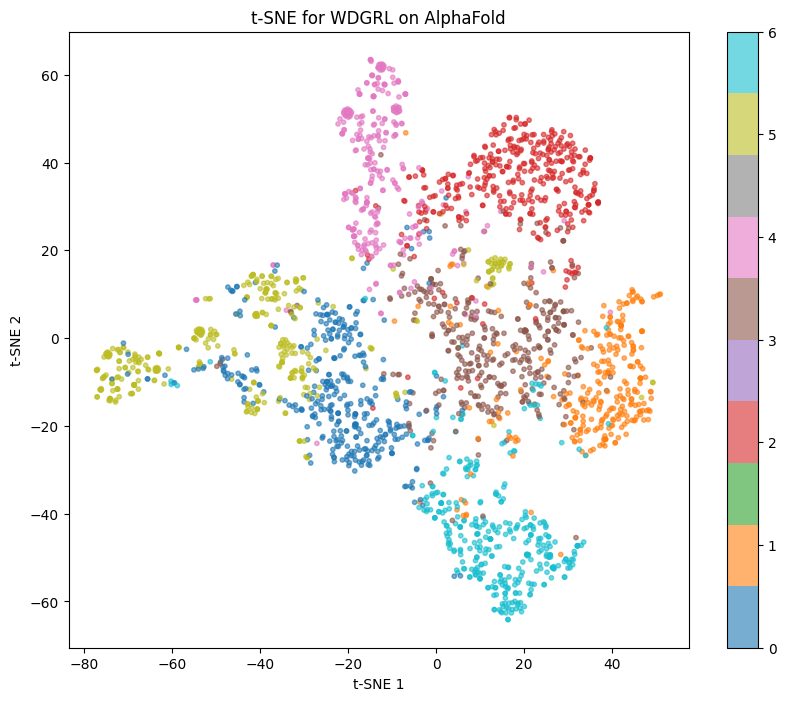

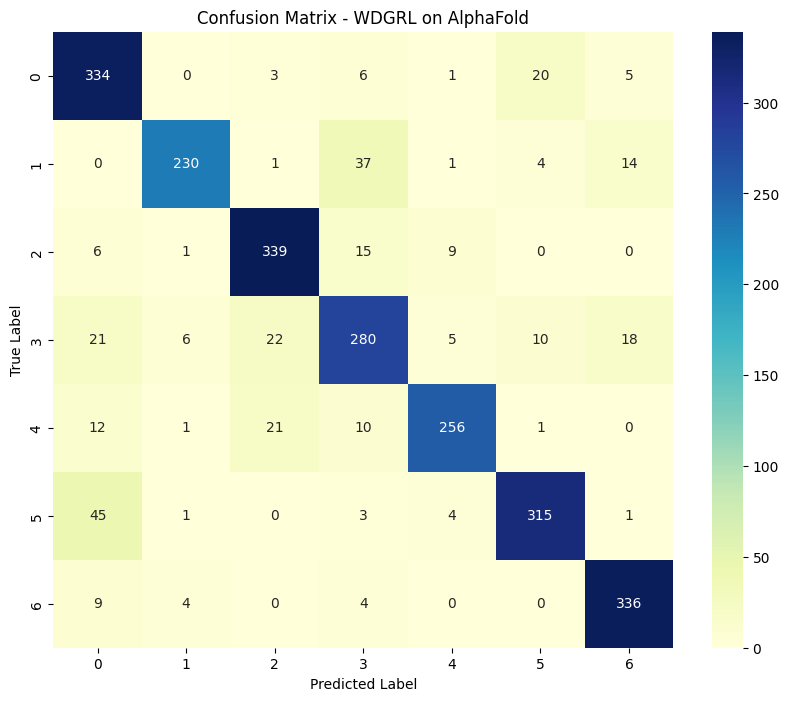


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       369
           1       0.95      0.80      0.87       287
           2       0.88      0.92      0.90       370
           3       0.79      0.77      0.78       362
           4       0.93      0.85      0.89       301
           5       0.90      0.85      0.88       369
           6       0.90      0.95      0.92       353

    accuracy                           0.87      2411
   macro avg       0.87      0.86      0.87      2411
weighted avg       0.87      0.87      0.87      2411



In [30]:
#Visualisation
model.eval()
features = []
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y_batch in test_af_loader:
        X = X.to(DEVICE)
        class_out, feat = model(X)
        preds = class_out.argmax(dim=1)

        features.append(feat.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.numpy())

features = np.concatenate(features)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter)
plt.title('t-SNE for WDGRL on AlphaFold')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('wdgrl_tsne.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - WDGRL on AlphaFold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('wdgrl_confusion.png')
plt.show()

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds))